### Import modules

In [2]:
"""This file is meant to explore and visualize the key takeaways from the paris bike
accident database found at the following link :
UPDATE LINK
https://www.data.gouv.fr/fr/datasets/comptage-velo-donnees-compteurs/"""

# Import section
import pandas as pd
import datetime
import numpy as np

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Import accident data

In [5]:
df = pd.read_csv("data/df_velos_merged.csv", index_col=0)

/var/folders/19/pckvwjyn0r7630jpjn3lh1800000gn/T/ipykernel_24599/378219190.py:1: DtypeWarning: Columns (15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/df_velos_merged.csv", index_col=0)


In [6]:
df.head()

,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,...,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
200500000030,2005-01-13,1,3 - jeudi,19.0,62,62331,50.300,2.840,oui,Hors intersection,...,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0
200500000034,2005-01-19,1,2 - mercredi,10.0,62,62022,0.000,0.000,non,Hors intersection,...,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0
200500000078,2005-01-26,1,2 - mercredi,13.0,02,02173,0.000,0.000,non,Autre intersection,...,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0
200500000093,2005-01-03,1,0 - lundi,13.0,02,02810,49.255,3.094,oui,Hors intersection,...,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0
200500000170,2005-01-29,1,5 - samedi,18.0,76,76196,0.000,0.000,non,Hors intersection,...,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0


### Clean data

In [8]:
# Rename column names

def under(str):
    return(str.replace(" ", "_"))
renamed = dict(zip(df.columns, df.columns.map(under)))
df.rename(columns = renamed, inplace=True)

In [9]:
# Convert datafields to their appropriate datatypes
def clean_date(string):
    try:
        return(pd.to_datetime(string[:-6], format = "%Y-%d-%m"))
    except:
        try:
            return(pd.to_datetime(string[:-6], format = "%Y-%m-%d"))
        except:
            return(pd.to_datetime(string, format = "%Y-%d-%m"))
    
df["clean_date"] = df["date"].apply(clean_date)

df["clean_date"] = df["clean_date"] + pd.to_timedelta(df["heure"], unit="h")

df.drop(columns = ["date"], inplace=True)
df.rename(columns={"clean_date": "date"}, inplace=True)

/Users/gilliankeusch/Desktop/cours_3A_CS/2_période/Challenge_IA/env2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/gilliankeusch/Desktop/cours_3A_CS/2_période/Challenge_IA/env2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [10]:
dico = {"Indemne" : 0, "Blessé léger" : 1, "Blessé hospitalisé " : 2, "Tué" : 3, "0 - Indemne" : 0,
       "1 - Blessé léger" : 1, "2 - Blessé hospitalisé" : 2, "3 - Tué" : 3, "Non renseigné" : -1}


dico_situation = {"Sur chaussée" : False, "Sur piste cyclable": True, "Sur trottoir" : False,
"Sur autre voie spéciale" : False, "Sur accotement" : False,
"Sur bande d’arrêt d’urgence" : False, "Autres" : False}

In [11]:
df["jour"] = df["jour"].apply(lambda x: x[0])
df["age"] = df["age"].astype("str").apply(lambda x : x.split("-", 1)[0])
df["age"] = df["age"].replace(np.nan, 0)
df["gravite_accident"] = df["gravite_accident"].replace(dico)
df["piste_cyclable"] = df["situation"].replace(dico_situation)

In [12]:
numerical_features = ["lat", "lon", "nb_voies", "largeur_TPC", "largeur_route", "nombre_autres_vehicules",
                      "jour", "gravite_accident", "age"]
boolean_features = ["en_agglomeration", "usage_securite"]
categorical_features = ["departement", "commune"]

for col in numerical_features :
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
for col in categorical_features :
    df[col] = df[col].astype("category")

for col in boolean_features :
    df[col] = df[col].str.lower().map({'oui':True ,'non':False})
    
# Drop useless fields

to_drop = ["mois", "heure"]
df.drop(to_drop, inplace=True, axis=1)

In [13]:
print(df.columns)

Index(['jour', 'departement', 'commune', 'lat', 'lon', 'en_agglomeration',
       'type_intersection', 'type_collision', 'luminosite',
       'conditions_atmosperiques', 'type_route', 'circulation', 'nb_voies',
       'profil_long_route', 'trace_plan_route', 'largeur_TPC', 'largeur_route',
       'etat_surface', 'amenagement', 'situation', 'categorie_usager',
       'gravite_accident', 'sexe', 'age', 'motif_deplacement',
       'existence_securite', 'usage_securite', 'obstacle_fixe_heurte',
       'obstacle_mobile_heurte', 'localisation_choc',
       'manoeuvre_avant_accident', 'identifiant_vehicule',
       'type_autres_vehicules', 'manoeuvre_autres_vehicules',
       'nombre_autres_vehicules', 'date', 'piste_cyclable'],
      dtype='object')


### Focus on Paris values

In [14]:
df.shape

(81617, 37)

In [15]:
df = df.loc[df["departement"]=="75"]

In [16]:
df.shape

(12902, 37)

### Explore numeric features

In [17]:
df.describe()

,jour,lat,lon,nb_voies,largeur_TPC,largeur_route,gravite_accident,age,nombre_autres_vehicules
count,12902.000000,12902.000000,12902.000000,12129.000000,988.000000,9509.000000,12864.000000,9786.000000,10623.000000
mean,2.748256,19.491499,0.935355,2.339682,51.636640,68.098012,0.934701,36.094318,0.964982
std,1.864288,23.926323,1.148444,1.356131,66.557975,59.424203,0.443421,14.890546,0.354514
min,0.000000,0.000000,0.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,10.000000,25.000000,1.000000,25.000000,1.000000
50%,3.000000,0.000000,0.000000,2.000000,22.500000,60.000000,1.000000,33.000000,1.000000
75%,4.000000,48.853458,2.335249,3.000000,78.000000,100.000000,1.000000,46.000000,1.000000
max,6.000000,48.901300,2.464630,28.000000,700.000000,770.000000,3.000000,95.000000,7.000000


### Explore nan values

In [18]:
for col in df.columns:
    print(col, df[col].isna().sum())

jour 0
departement 0
commune 0
lat 0
lon 0
en_agglomeration 3113
type_intersection 0
type_collision 0
luminosite 0
conditions_atmosperiques 0
type_route 0
circulation 9789
nb_voies 773
profil_long_route 314
trace_plan_route 878
largeur_TPC 11914
largeur_route 3393
etat_surface 256
amenagement 9109
situation 508
categorie_usager 38
gravite_accident 38
sexe 38
age 3116
motif_deplacement 1924
existence_securite 1249
usage_securite 7284
obstacle_fixe_heurte 9596
obstacle_mobile_heurte 1601
localisation_choc 1357
manoeuvre_avant_accident 246
identifiant_vehicule 38
type_autres_vehicules 2279
manoeuvre_autres_vehicules 2460
nombre_autres_vehicules 2279
date 151
piste_cyclable 508


In [19]:
to_drop = ["circulation", "amenagement", "usage_securite", "obstacle_fixe_heurte", "largeur_TPC", "largeur_route", "situation",
            "lat", "lon"
]
df = df.drop(columns = to_drop)

In [20]:
to_drop_macro = ["en_agglomeration", 'motif_deplacement', "existence_securite",
                 "obstacle_mobile_heurte", "localisation_choc", "manoeuvre_autres_vehicules",
                "type_autres_vehicules", "manoeuvre_avant_accident", "profil_long_route",
                "etat_surface", "trace_plan_route", "nombre_autres_vehicules"]
df = df.drop(columns = to_drop_macro)

In [21]:
for col in df.columns:
    print(col, df[col].isna().sum())

print(df.shape)
df.head()

jour 0
departement 0
commune 0
type_intersection 0
type_collision 0
luminosite 0
conditions_atmosperiques 0
type_route 0
nb_voies 773
categorie_usager 38
gravite_accident 38
sexe 38
age 3116
identifiant_vehicule 38
date 151
piste_cyclable 508
(12902, 16)


,jour,departement,commune,type_intersection,type_collision,luminosite,conditions_atmosperiques,type_route,nb_voies,categorie_usager,gravite_accident,sexe,age,identifiant_vehicule,date,piste_cyclable
200500004591,1,75,75001,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Voie Communale,2.0,Conducteur,1.0,M,36.0,200500004591B01,2005-01-01 17:00:00,False
200500004597,0,75,75005,Intersection en X,Deux véhicules - par l’arrière,Plein jour,Normale,Voie Communale,3.0,Conducteur,0.0,M,26.0,200500004597A01,2005-01-01 09:00:00,False
200500004600,0,75,75019,Intersection en T,Autre,Nuit avec éclairage public allumé,Normale,Voie Communale,4.0,Conducteur,0.0,M,31.0,200500004600A01,2005-01-01 17:00:00,False
200500004627,2,75,75007,Intersection en T,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Pluie légère,Voie Communale,2.0,Conducteur,1.0,M,57.0,200500004627A01,2005-01-01 18:00:00,False
200500004630,2,75,75013,Intersection en T,Deux véhicules - par le coté,Plein jour,Pluie légère,Voie Communale,4.0,Conducteur,1.0,F,26.0,200500004630B01,2005-01-01 08:00:00,False


In [22]:
df = df.dropna()

In [23]:
df.shape

(8471, 16)

### Categorical features

In [24]:
df["arrondissement"] = df["commune"].apply(lambda x : x[-2:])

In [25]:
other_cat = ["departement", "type_intersection", "type_collision",
             "identifiant_vehicule", "date", "commune"]

In [26]:
df.drop(columns = other_cat, inplace=True)
df.columns

Index(['jour', 'luminosite', 'conditions_atmosperiques', 'type_route',
       'nb_voies', 'categorie_usager', 'gravite_accident', 'sexe', 'age',
       'piste_cyclable', 'arrondissement'],
      dtype='object')

### Preprocessing

In [27]:
## One hot encoding when needed

In [28]:
one_hot = ["luminosite", "type_route", "conditions_atmosperiques",
           "categorie_usager", "sexe", "arrondissement", "piste_cyclable"]
df_one_hot = df[one_hot]

In [29]:
df_one_hot = pd.get_dummies(df_one_hot)
df = pd.concat([df, df_one_hot], axis=1)
df = df.drop(one_hot, axis = 1)

In [30]:
## Scaling our data

In [31]:
template = df.columns
template = template.drop("gravite_accident")
template

Index(['jour', 'nb_voies', 'age', 'luminosite_Crépuscule ou aube',
       'luminosite_Nuit avec éclairage public allumé',
       'luminosite_Nuit avec éclairage public non allumé',
       'luminosite_Nuit sans éclairage public', 'luminosite_Plein jour',
       'type_route_Autre', 'type_route_Hors réseau public',
       'type_route_Parc de stationnement ouvert à la circulation publique',
       'type_route_Route Départementale', 'type_route_Route Nationale',
       'type_route_Voie Communale', 'conditions_atmosperiques_Autre',
       'conditions_atmosperiques_Brouillard - fumée',
       'conditions_atmosperiques_Neige - grêle',
       'conditions_atmosperiques_Normale',
       'conditions_atmosperiques_Pluie forte',
       'conditions_atmosperiques_Pluie légère',
       'conditions_atmosperiques_Temps couvert',
       'conditions_atmosperiques_Temps éblouissant',
       'conditions_atmosperiques_Vent fort - tempête',
       'categorie_usager_Conducteur', 'categorie_usager_Passager',
   

In [42]:
df.to_csv("data/data_model.csv")

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns="gravite_accident"), df["gravite_accident"], test_size=0.2)

In [35]:
scaler = StandardScaler()
to_scale = ['jour',
#'lat', 'lon',
        'nb_voies', 'age']
for col in to_scale:
    x_train[col] = scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col] = scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [44]:
x_train.head()

,jour,nb_voies,age,luminosite_Crépuscule ou aube,luminosite_Nuit avec éclairage public allumé,luminosite_Nuit avec éclairage public non allumé,luminosite_Nuit sans éclairage public,luminosite_Plein jour,type_route_Autre,type_route_Hors réseau public,...,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_20,piste_cyclable_False,piste_cyclable_True
200700029982,-1.451002,-0.176120,-2.280368,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
201700056748,1.223933,-0.176120,-0.617442,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
201400054175,0.153959,-0.176120,1.644137,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
200900009201,1.223933,-0.949543,-0.085306,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
201000063817,0.153959,-0.176120,-1.016544,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [45]:
y_train.head()

200700029982    1.0
201700056748    0.0
201400054175    1.0
200900009201    1.0
201000063817    1.0
Name: gravite_accident, dtype: float64

In [46]:
import json
json.dump({"template": template.tolist()}, open("data/template.json", "w"))

### Regression models

In [47]:
def Linear():
    # Create regressor
    clf = LinearRegression()
    # Fit on the training set
    clf.fit(x_train, y_train)
    # Create predictions
    pred = clf.predict(x_test)
    # Print the accuracy and root mean square error
    acc = clf.score(x_test,y_test)
    rmse = metrics.mean_squared_error(y_test, pred, squared = False)
    return(clf, acc, rmse)

In [48]:
Linear()

(LinearRegression(), 0.037441041252278984, 0.45541447650128675)

In [49]:
def knn():
    error = []
    for i in range(1, 40):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x_train, y_train)
        pred_i = knn.predict(x_test)
        mse = metrics.mean_squared_error(y_test, pred_i, squared = False)
        error.append(mse)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', 
            linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    plt.title('K Value kMSE')
    plt.xlabel('K Value')
    plt.ylabel('Root Mean Squared Error')
    plt.show()

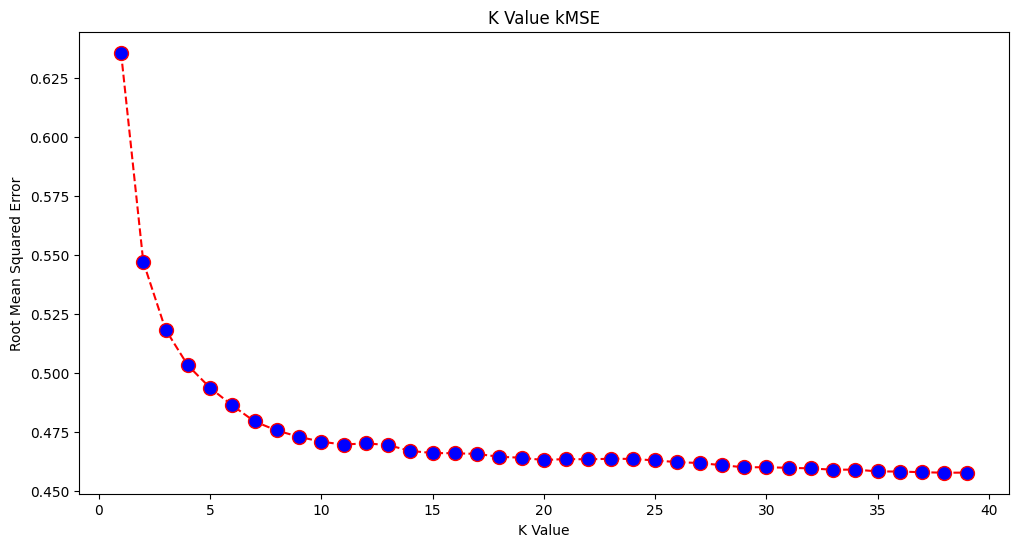

In [50]:
knn()

In [51]:
def regression(n):
# Create regressor
    clf = KNeighborsRegressor(8)
    # Fit on the training set
    clf.fit(x_train, y_train)
    # Create predictions
    pred = clf.predict(x_test)
    # Print the accuracy and root mean square error
    acc = clf.score(x_test,y_test)
    rmse = metrics.mean_squared_error(y_test, pred, squared = False)
    return(clf, acc, rmse)

In [52]:
regression(8)

(KNeighborsRegressor(n_neighbors=8), -0.05004846135207153, 0.47566131576536075)

In [53]:
def decision_tree_grid_search(data, param_grid):
    """returns the parameters that give the best result among the ones in your param_grid"""
    y = data['gravite_accident']
    X = data.drop('gravite_accident', axis = 1)
    regressor = tree.DecisionTreeRegressor()
    grid = GridSearchCV(regressor, param_grid = param_grid, cv = 10,verbose = 1, n_jobs = -1)
    grid.fit(X,y)
    return grid.best_params_

def Decision_Tree(max_depth, min_samples_leaf, min_samples_split):
    """returns RMSE and R2 for decision tree"""
    regressor = tree.DecisionTreeRegressor(
    max_depth = max_depth,
    min_samples_leaf = min_samples_leaf,
    min_samples_split = min_samples_split)
    regressor = regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = metrics.r2_score(y_test,y_pred)
    return regressor, R2, RMSE

In [54]:
param_grid = {'max_depth':[2,3,4,5,6,8,10,12],"min_samples_split": range(1,10), 'min_samples_leaf':range(1,5)}

#print(decision_tree_grid_search(df, param_grid))  

In [55]:
Decision_Tree(max_depth = 3, min_samples_leaf = 4, min_samples_split = 2)

(DecisionTreeRegressor(max_depth=3, min_samples_leaf=4),
 0.02453310595647107,
 0.45845786621538986)

In [56]:
def Grid_search(train, param_grid):
    """returns the parameters that give the best result among the ones in your param_grid"""    
    # Create the parameter grid based on the results of random search 
    y = train['gravite_accident']
    X = train.drop('gravite_accident', axis = 1)
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y)
    return grid_search.best_params_

def Random_Forest( max_depth, max_features, n_estimators):
    """returns RMSE and R2 for random forest"""
    regressor = RandomForestRegressor(bootstrap = True,
                max_depth = max_depth,
                max_features = max_features,
                n_estimators = n_estimators)
    regressor = regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = metrics.r2_score(y_test,y_pred)
    return regressor, R2, RMSE


param_grid = {
        'max_depth': [44, 45, 46, 47, 48, 49],
        'n_estimators': [850, 875, 900, 925]
    }

In [57]:
#Grid_search(df, param_grid)

In [58]:
Random_Forest(max_depth = 48, max_features = 'sqrt', n_estimators = 900)

(RandomForestRegressor(max_depth=48, max_features='sqrt', n_estimators=900),
 -0.06996883589435265,
 0.480151981759194)

In [59]:
# Ecrire fonction pour prédire une gravité à partir d'un modèle fixé (donc prendre avant le one hot etc)
# Faire vis avec la répartition piste_cyclable

### Predictions

In [60]:
def check(entry,categ,value):
    one_hot_encoder=[]
    for k in range(len(template)):
        if template[k][:len(categ)]==categ:
            if template[k][len(categ):]==value:
                one_hot_encoder.append(1)
            else:
                one_hot_encoder.append(0)
    return one_hot_encoder

def one_hot_encode(entry):
    L=[]
    L.append(entry[0]) #jour 
    L.append(entry[4]) #nb voies
    L.append(entry[7]) #age
    
    L+=check(entry,"luminosite_",entry[1])

    L+=check(entry,"type_route_",entry[3])

    L+=check(entry,"conditions_atmosperiques_",entry[2])

    L+=check(entry,"categorie_usager_",entry[5])

    L+=check(entry,"sexe_",entry[6])

    L+=check(entry,"arrondissement_",entry[9])

    L+=check(entry,"piste_cyclable_",entry[8])

    return L

#one_hot_encode([0.98, 'Plein jour', 'Normale', "Autre",'1', 'Piéton', 'M', 20,'True', 13])

In [61]:
def prediction(regressor, features:list):

   x_val = pd.DataFrame(columns=template)
   x_val.loc[1] = one_hot_encode(features)

   scaler = StandardScaler()
   to_scale = ['jour', 'nb_voies', 'age']
   for col in to_scale:
      x_val[col] = scaler.fit_transform(np.array(x_val[col]).reshape(-1,1))

   y_pred = regressor.predict(x_val)[0]
   print("La gravité prédite de l'accident, allant de 0 (Blessé léger) à 3 (Tué) est de {}".format(y_pred))
   return(y_pred)

In [62]:
x_train.columns

Index(['jour', 'nb_voies', 'age', 'luminosite_Crépuscule ou aube',
       'luminosite_Nuit avec éclairage public allumé',
       'luminosite_Nuit avec éclairage public non allumé',
       'luminosite_Nuit sans éclairage public', 'luminosite_Plein jour',
       'type_route_Autre', 'type_route_Hors réseau public',
       'type_route_Parc de stationnement ouvert à la circulation publique',
       'type_route_Route Départementale', 'type_route_Route Nationale',
       'type_route_Voie Communale', 'conditions_atmosperiques_Autre',
       'conditions_atmosperiques_Brouillard - fumée',
       'conditions_atmosperiques_Neige - grêle',
       'conditions_atmosperiques_Normale',
       'conditions_atmosperiques_Pluie forte',
       'conditions_atmosperiques_Pluie légère',
       'conditions_atmosperiques_Temps couvert',
       'conditions_atmosperiques_Temps éblouissant',
       'conditions_atmosperiques_Vent fort - tempête',
       'categorie_usager_Conducteur', 'categorie_usager_Passager',
   

In [64]:
#format de base : ["jour", 'luminosite', 'conditions_atmosperiques', 'type_route',
# 'nb_voies', 'categorie_usager', 'sexe', 'age', 'piste_cyclable', "arrondissement"]
features_low = [1, 'Plein jour', 'Normale', "Autre", 1, 'Piéton', 'F', 50, "True", "1"]
features_high = [5, 'Nuit sans éclairage public', 'Normale', "Autre", 2, 'Conducteur', 'M', 20, "False", "20"]
prediction(Decision_Tree(max_depth = 3, min_samples_leaf = 4, min_samples_split = 2)[0], features_low)
#prediction(Linear()[0], features)
#prediction(regression(8)[0], features_low)
#prediction(Random_Forest(max_depth = 48, max_features = 'sqrt', n_estimators = 900)[0], features_low)
prediction(Decision_Tree(max_depth = 3, min_samples_leaf = 4, min_samples_split = 2)[0], features_high)
#prediction(Linear()[0], features)
#prediction(regression(8)[0], features_high)
#prediction(Random_Forest(max_depth = 48, max_features = 'sqrt', n_estimators = 900)[0], features_high)

La gravité prédite de l'accident, allant de 0 (Blessé léger) à 3 (Tué) est de 0.9946091644204852
La gravité prédite de l'accident, allant de 0 (Blessé léger) à 3 (Tué) est de 0.8972230174634984


0.8972230174634984